### Initial playground for domain adaptation and moving into active learning

* Paul Blankley 

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.active_learning as al
import src.viz as viz

import importlib as imp
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import pyro

%matplotlib inline

In [3]:
# Get raw datasets 
train_set = dset.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=False)
test_set = dset.MNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=len(test_set),shuffle=False)

In [4]:
# Get x/y split for the test set 
train_x, train_y, val_x, val_y = al.get_dataset_split(train_set)
test_x,test_y = al.get_xy_split(test_loader)

### Idea:

You start with 64 random points to make a model. Then you get to choose 16 points to have the labels given to you.  Just pass a policy function that decides which policy to follow to get the new points.  Then compare the two policies and show that the "active learning" (with intelligent policy performs better).

In [30]:
# Define the logistic regression model
class logreg(nn.Module):
    """ Logistic regression """
    def __init__(self, classes):
        super(logreg, self).__init__()
        self.classes = classes
        self.w = nn.Linear(28*28,classes)
        
    def forward(self, x):
        x = self.w(x.view(-1,1,28*28))
        return F.log_softmax(x.view(-1,self.classes),dim=1)

# Define the CNN model 
class CNN(nn.Module):
    """ CNN for MNIST """
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


False

0.9698

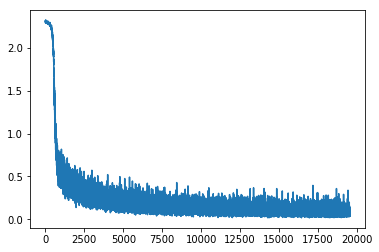

In [31]:
cnn = CNN()
opt = optim.SGD(cnn.parameters(), lr=.01)

experiment = al.ExperiAL(cnn, train_x, train_y, val_x, val_y, loss_func, opt)
it, ac = experiment._train(train_x, train_y, epochs=50, batch_size=128)

plt.plot(it,ac)
al.accuracy(cnn,val_x,val_y)

In [28]:
al = imp.reload(al)
viz = imp.reload(viz)

# model = logreg(classes=10)
# loss_func = nn.NLLLoss()
# optimizer = optim.SGD(model.parameters(), lr=.01)
# experiment = al.ExperiAL(model, train_x, train_y, val_x, val_y, loss_func, optimizer)
# experiment.active_learn(policy='boundary', meta_epochs=5, epochs_per_train=5, npoints=20, batch_size=10)

### Active learning policy experiments

*describe

In [61]:
########### GLOBAL EXPERIMENT PARAMS ############
# Epochs of adding additional points
meta_epochs = 5
# Epochs per training run
ept = 5
# Number of points to start with and add each run 
npoints = 20
batch_size = 10
learning_rate = 0.01
# Number of runs to create a sampling distribution to quantify error 
samp_runs = 5

#################################################

def try_policy(policy, meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs):
    # general policy test 
    try_acc = []
    for i in tqdm(range(samp_runs)):
        model_try = logreg(classes=10)
        loss_try = nn.NLLLoss()
        optimizer_try = optim.SGD(model_try.parameters(), lr=learning_rate)
        experi = al.ExperiAL(model_try, train_x, train_y, val_x, val_y, loss_try, optimizer_try)
        _, val_acc = experi.active_learn(policy=policy, epochs_per_train=ept, npoints=npoints, \
                                            batch_size=batch_size, meta_epochs=meta_epochs)
        try_acc.append(val_acc)
    print(f'Active Learning with {policy} policy done!')
    return try_acc

al = imp.reload(al)
# random_acc = try_policy('random', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)
# boundary_acc = try_policy('boundary', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)
# entropy_acc = try_policy('max_entropy', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)
# confidence_acc = try_policy('conf', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)
uniform_acc = try_policy('uniform', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)

A Jupyter Widget

[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]



Exception in thread Thread-32:
Traceback (most recent call last):
  File "/Users/paulblankley/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/paulblankley/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/paulblankley/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
[0, 0, 1, 1, 2, 2, 3, 3,

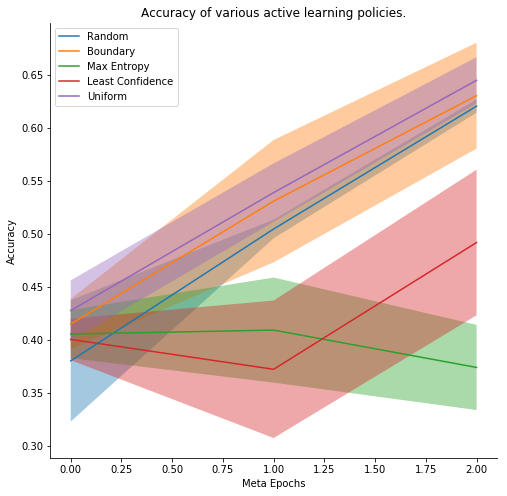

In [27]:
accs = [random_acc,boundary_acc,entropy_acc, confidence_acc,uniform_acc]
labs = ['Random','Boundary','Max Entropy', 'Least Confidence','Uniform']
viz.plot_results(meta_epochs,accs,labs)

In [ ]:
# add cluster policy?
# reinforce learn the policies

1 epoch acc 0.8274
OrderedDict([('w.weight', 
-6.8073e-03 -1.2734e-02  1.2037e-03  ...  -6.9628e-03  2.0184e-04  3.4872e-02
 2.7569e-03  4.4934e-03 -9.3707e-03  ...   3.2284e-02  1.1755e-03  5.7668e-03
-1.6604e-02  2.1648e-02 -2.2664e-03  ...   1.1570e-02 -1.7593e-02 -1.0135e-02
                ...                   ⋱                   ...                
-2.4246e-02  3.1642e-02  1.6014e-02  ...  -7.5362e-03 -2.8991e-02 -3.3418e-03
-3.3932e-02  2.7577e-02  2.5030e-02  ...  -3.4383e-02 -4.4925e-03 -2.2191e-02
-3.1139e-02  1.9497e-02 -2.2492e-03  ...  -4.9086e-03  2.7648e-03  3.3942e-02
[torch.FloatTensor of size 10x784]
), ('w.bias', 
1.00000e-02 *
 -3.6556
  8.6148
 -1.0230
  1.4865
  4.8212
 -0.1172
  0.2096
 -0.9782
 -6.9836
 -3.2196
[torch.FloatTensor of size 10]
)])
OrderedDict([('w.weight', 
-6.8073e-03 -1.2734e-02  1.2037e-03  ...  -6.9628e-03  2.0184e-04  3.4872e-02
 2.7569e-03  4.4934e-03 -9.3707e-03  ...   3.2284e-02  1.1755e-03  5.7668e-03
-1.6604e-02  2.1648e-02 -2.2664e-03 

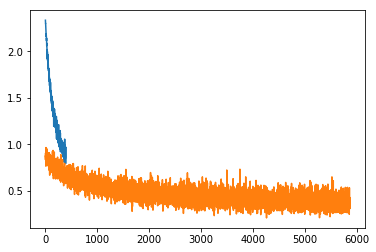

In [45]:
from collections import namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

model = logreg(classes=10)
loss_func = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=.01)
experiment = al.ExperiAL(model, train_x, train_y, val_x, val_y, loss_func, optimizer)
it,ac = experiment._train(train_x, train_y, epochs=1, batch_size=128)

plt.plot(it,ac)
sd = model.state_dict()
print('1 epoch acc',al.accuracy(model,val_x,val_y))
print(sd)
it,ac = experiment._train(train_x, train_y, epochs=15, batch_size=128)
plt.plot(it,ac)
sd2 = model.state_dict()
print(sd2)
print('20 epoch acc',al.accuracy(model,val_x,val_y))
print(sd)
model.load_state_dict(sd)
model.state_dict()
print('should be 5 epoch acc',al.accuracy(model,val_x,val_y))


In [53]:
preds = [5,5,6,7,8,4,3,2]
num_points, sampler = len(preds), np.array(range(len(preds)))
# output = []
for i in range(num_points):
    print(np.random.choice(preds, size=num_points, replace=False))

[6 7 3 5 5 2 4 8]
[5 4 7 3 8 2 6 5]
[2 6 8 4 5 5 7 3]
[7 4 3 2 6 8 5 5]
[8 6 5 5 3 2 7 4]
[4 5 8 7 5 3 2 6]
[8 5 3 5 4 7 2 6]
[3 7 5 5 2 8 6 4]
